# Music Theory:

## Terminology:

* Pitch: refers to the frequency of the sound, or how high or low it is and is represented with the letters [A, B, C, D, E, F, G], with A being the highest and G being the lowest.
* Octave: refers to which set of pitches you use on a piano.
* Offset: refers to where the note is located in the piece.

In [1]:
# import some useful libraries
import glob
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import metrics

from tqdm.notebook import tqdm
from music21 import converter, instrument, note, chord

c:\Users\ktrin\miniconda3\envs\tf\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\ktrin\miniconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\ktrin\miniconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
print(tf.config.list_physical_devices('GPU'))

[]


In [3]:
# read in music and prepare it in a list of notes
notes = []
for file in tqdm(glob.glob("../data/midi_songs/*.mid")):
    midi = converter.parse(file)
    notes_to_parse = None
    
    # Two cases:
    # 1. music file has instrument parts
    # 2. music file has notes in a flat structure
    try: # file has instrument parts
        s2 = instrument.partitionByInstrument(midi)
        notes_to_parse = s2.parts[0].recurse() 
    except: # file has notes in a flat structure
        notes_to_parse = midi.flat.notes
        
    # each note elements exported and append to an array of notes
    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))

  0%|          | 0/92 [00:00<?, ?it/s]

In [20]:
# Data Pre-processing:
# 1. get all pitch name
pitchnames = sorted(set(item for item in notes))

# 2. create a dictionary to map pitches to integers (essentially OHE the pitches)
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

# 3. Creating a input/output sequences for the neural network
# The output for each sequence of length 100 is the first note or chord that come after the sequence of notes
sequence_length = 100
network_input = []
network_output = []

# create input sequences and the corresponding outputs
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    
    # map the input/output string(s) to a numerical value for training purposes
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])


# determine the number of different pattern generated
n_patterns = len(network_input)

# reshape the input into a format compatible with LSTM layers
# essentially, the array of array is to be reshape by(x_pattern, y_length, )
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))

# Post processing on input/outputs
# normalize input
# OHE the output -> so that softmax can be use to generate a probability
network_input = network_input / float(len(pitchnames))
network_output = tf.keras.utils.to_categorical(network_output)
print(network_input.shape, network_output.shape)

(45872, 100, 1) (45872, 326)


In [161]:
def build_LSTM(lstm_dim=512, dense_layer_dim=256, dropout_rate=0.3):
    """
        LSTM architecture music generator
    """

    # clear any previous architecture
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    input_layer = tf.keras.layers.Input(shape=(network_input.shape[1], network_input.shape[2]), name='input_layer')
    
    
    forward_lstm_layer = tf.keras.layers.LSTM(lstm_dim,
                            return_sequences=True, 
                            return_state=True, 
                            recurrent_dropout=dropout_rate,
                            name='forward_lstm_layer')

    forward_output, forward_state_h, forward_state_c = forward_lstm_layer(input_layer)
    
    reverse_lstm_layer = tf.keras.layers.LSTM(lstm_dim,
                            return_sequences=True, 
                            return_state=True, 
                            recurrent_dropout=dropout_rate,
                            go_backwards=True,
                            name='reverse_lstm_layer')
    
    reverse_output, reverse_state_h, reverse_state_c = reverse_lstm_layer(input_layer)
    
    
    # add attention to attend forward and backward layers together:
    attention_context_vectors = tf.keras.layers.Attention(name='attention_layer')([forward_output, reverse_output])

    # append attention to forward vector to and feed into fully connected layer
    concat_output_layer = tf.keras.layers.Concatenate(axis=-1, name='concat_layer_with_att')([forward_output, attention_context_vectors])

    # feed concatentation layer to 1 more LSTM layer
    # normalized the output
    # feed the normalized output to fully connected deep layer
    forward_lstm_layer_2 = tf.keras.layers.LSTM(concat_output_layer.shape[2], name='forward_lstm_layer_2')    
    forward_2_output = forward_lstm_layer_2(concat_output_layer)
    normalization_layer = keras.layers.BatchNormalization(name="normalize_1")
    normalized_output = normalization_layer(forward_2_output)

    # add a hidden dense layer
    last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(normalized_output)
    last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(last_hidden_output)
    
    # perform batch normalization
    normalization_layer = keras.layers.BatchNormalization(name="normalize_2")
    normalized_output = normalization_layer(last_hidden_output)
    
    # add the final softmax classification layer
    lstm_prediction = keras.layers.Dense(len(pitchnames), activation='softmax')(normalized_output)
    lstm_model = keras.Model(inputs=input_layer, outputs=lstm_prediction)
    lstm_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy'])
    return lstm_model


In [162]:
# set up the model and see how it look like (saving some checkpoints for later)
filepath = "../data/trainig_outputs/bidirectional/weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"    
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)    
callbacks_list = [checkpoint]     

In [163]:
lstm_model = build_LSTM(lstm_dim=512, dense_layer_dim=256, dropout_rate=0.3)
lstm_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 100, 1)]     0           []                               
                                                                                                  
 forward_lstm_layer (LSTM)      [(None, 100, 512),   1052672     ['input_layer[0][0]']            
                                 (None, 512),                                                     
                                 (None, 512)]                                                     
                                                                                                  
 reverse_lstm_layer (LSTM)      [(None, 100, 512),   1052672     ['input_layer[0][0]']            
                                 (None, 512),                                                 

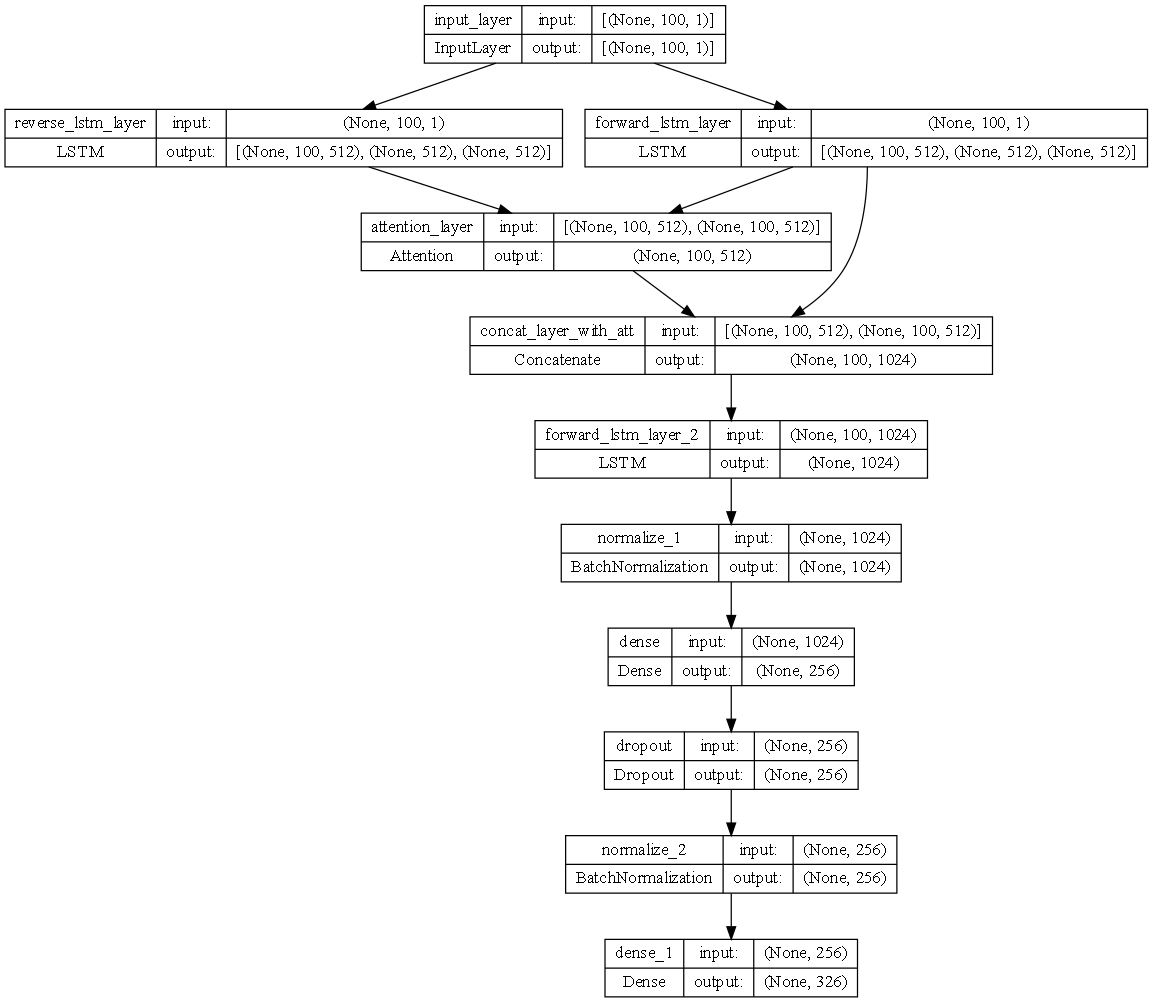

In [164]:
keras.utils.plot_model(lstm_model, show_shapes=True, dpi=90)

In [ ]:
lstm_model.fit(network_input, network_output, epochs=200, batch_size=128, callbacks=callbacks_list)

Epoch 1/200
359/359 [==============================] - 656s 2s/step - loss: 4.9693 - accuracy: 0.0295
Epoch 2/200
359/359 [==============================] - 653s 2s/step - loss: 4.4997 - accuracy: 0.0342
Epoch 3/200
359/359 [==============================] - 649s 2s/step - loss: 4.4714 - accuracy: 0.0364
Epoch 4/200
359/359 [==============================] - 648s 2s/step - loss: 4.4519 - accuracy: 0.0398
Epoch 5/200
359/359 [==============================] - 640s 2s/step - loss: 4.4291 - accuracy: 0.0420
Epoch 6/200
359/359 [==============================] - 676s 2s/step - loss: 4.4139 - accuracy: 0.0434
Epoch 7/200
359/359 [==============================] - 642s 2s/step - loss: 4.4001 - accuracy: 0.0453
Epoch 8/200
359/359 [==============================] - 639s 2s/step - loss: 4.3863 - accuracy: 0.0463
Epoch 9/200
359/359 [==============================] - 644s 2s/step - loss: 4.3761 - accuracy: 0.0479
Epoch 10/200
359/359 [==============================] - 647s 2s/step - loss: 4.364

In [67]:
# Designing the Neural network:

# Start a new session before training/clear out everything prior
# This is not strictly necessary, but each time you build a model, TF adds
# new nodes (rather than overwriting), so the colab session can end up
# storing lots of copies of the graph when you only care about the most
# recent. Also, as there is some randomness built into training with SGD,
# setting a random seed ensures that results are the same on each identical
# training run.
tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)

# Build a model using keras.Sequential.
model = keras.Sequential()

# Input a row of data into an LSTM layer
model.add(keras.layers.LSTM(
    512, 
    input_shape=(network_input.shape[1], network_input.shape[2]), 
    recurrent_dropout=0.3,
    return_sequences=True))


model.add(keras.layers.LSTM(512, return_sequences=True, recurrent_dropout=0.3,))
model.add(keras.layers.LSTM(512, return_sequences=True, recurrent_dropout=0.3,))
model.add(keras.layers.LSTM(512))
model.add(keras.layers.BatchNormalization())

# dropout ~30% of the first LSTM layer as a regularization technique
# Useful to prevent overfitting
model.add(keras.layers.Dropout(0.3))

# Add some hidden layers/ one more level of dropout layers
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.3))

# output layer with softmax activation on all the 
model.add(keras.layers.Dense(
    units = len(pitchnames),
    activation = "softmax"
))
          
# compile the model 
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

# model.load_weights('../data/trainig_outputs/weights-improvement-53-0.7322-bigger.hdf5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 512)          1052672   
                                                                 
 lstm_1 (LSTM)               (None, 100, 512)          2099200   
                                                                 
 lstm_2 (LSTM)               (None, 100, 512)          2099200   
                                                                 
 lstm_3 (LSTM)               (None, 512)               2099200   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

In [6]:
# fit the model
filepath = "../data/trainig_outputs/weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"    
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)    
callbacks_list = [checkpoint]     


Epoch 1/200
359/359 [==============================] - 1090s 3s/step - loss: 0.7239 - accuracy: 0.7797
Epoch 2/200
359/359 [==============================] - 979s 3s/step - loss: 0.7021 - accuracy: 0.7848
Epoch 3/200
359/359 [==============================] - 1017s 3s/step - loss: 0.6674 - accuracy: 0.7968
Epoch 4/200
359/359 [==============================] - 1074s 3s/step - loss: 0.6368 - accuracy: 0.8037
Epoch 5/200
359/359 [==============================] - 1024s 3s/step - loss: 0.6308 - accuracy: 0.8069
Epoch 6/200
359/359 [==============================] - 1001s 3s/step - loss: 0.6229 - accuracy: 0.8108
Epoch 7/200
359/359 [==============================] - 1040s 3s/step - loss: 0.5860 - accuracy: 0.8191
Epoch 8/200
359/359 [==============================] - 1030s 3s/step - loss: 0.5701 - accuracy: 0.8244
Epoch 9/200
359/359 [==============================] - 1027s 3s/step - loss: 0.5615 - accuracy: 0.8276
Epoch 10/200
359/359 [==============================] - 1030s 3s/step - lo

KeyboardInterrupt: 

In [ ]:
model.fit(network_input, network_output, epochs=200, batch_size=128, callbacks=callbacks_list)